---
title: "Topic-modeling on Philosophy of Biology"
date: 2025-04-28
author:
  - name: Jacob Hamel-Mottiez
    id: jhm
    orcid: 0009-0007-3666-908X
    email: jacob.hamel-mottiez.1@ulaval.ca
    affiliation: 
      - name: Laval University

abstract:
    This file is the technical appendix for my master's thesis. 

#execute: 
  #freeze: auto  # re-render only when source changes
  #enabled: true # This is so that Plotly is rendered. 

keywords:
  - Philosophy of Biology
  - Biology
  - Bibliometrics
  - Topic modeling
  - BERTopic


engine: jupyter
brand:
  light: lightly
  dark: darkly
keep-md: true
# an alternative to calling display() for each plot
ipynb-shell-interactivity: all


license: "CC BY"
copyright: 
  holder: Jacob Hamel-Mottiez
  year: 2024
funding: "The author received funding from the Social Sciences and Humanities Canadian Reseach Council (SSHCRC) as well as from the Fonds de recherche du Québec - Société et culture."
---

## Introduction 
This project is called "What is Philosophy of Biology" (WIPOP). Is is part of my master's thesis in philosophy of science. In this master, one of my goal was to investigate the thematic diversity of philosophy of biology. Given that it is often the case that philosophy of biology of biology discribes itself as on a continuum with biology, I wanted to know if the thematics of the two endeavors matched, at least partially.

Some previous results, notably Gayon (2009), Pradeu (2017) and Malaterre et al. (2021) looked at the thematic diversity of philosophy of biology through one main journal : Biology and Philosophy. Gayon and Pradeu classified manually all the articles. The categories in which they fall have been built iteratively. Malaterre leveraged well-known topic modeling algorithm Latent Dirichilet Allocation (LDA). Howerver, given that Gayon and Pradeu manual annotation attribute a unique theme per article whereas Malaterre with LDA gives the probability to find a topic in a document (which have many of them), the two analysis are hard to compare.

Thus, we decided to use a state of the art topic modeling algorithm : BERTopic (Grootendorst, 2022). With it, we were able to attribute a single theme by article, thus making our analysis comparable with the one of Pradeu, himself extending the previous work of Gayon. Moreover, we looked at the four major journals in philosophy of biology. You will find in this file all the description of how we achieved it

::: {.callout-warning}
Given that we used proprietary data from Scopus, we can't unfortunatly share it. However, it should not be hard to reproduce our analysis if you have access to Scopus.  
:::

## Setup ℹ️

In [3]:
#Directories
DATA_PHILO = "C:/Users/jacob/OneDrive - Université Laval/biophilo/Data/pybiblio/SPECIALIZED PHILOSOPHY OF BIOLOGY/articles_special_philo_bio_reformat.csv"

PATH_TO_VIZ = r"C:/Users/jacob/OneDrive - Université Laval/biophilo/Visualisation"

# Packages to import. 
import pandas as pd 
import numpy as np
import datamapplot

from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from itables import show

## Data📄
This data is from Philosophy of Biology journal from 1986 to 2024. I removed all the entries with no abstract. 


In [4]:
df = pd.read_csv("C:/Users/jacob/OneDrive - Université Laval/biophilo/Data/pybiblio/SPECIALIZED PHILOSOPHY OF BIOLOGY/articles_special_philo_bio_reformat.csv")
df = df.fillna("NULL")

print("Total number of documents: ",df.citing_id.count())

Total number of documents:  4287


It is important to note that out of these 4,287, not all of them are articles. Here is the count of the various documents by document types : 

In [5]:
unique_values = df['subtypeDescription'].unique()

# Create a new DataFrame with unique values of 'citing_year'
unique_values_df = pd.DataFrame(unique_values, columns=['subtypeDescription'])

# If you want to count how many times each unique value appears in the original DataFrame
value_counts = df['subtypeDescription'].value_counts()

# Optionally, you can merge the unique values with the count if needed
unique_values_df['Count'] = unique_values_df['subtypeDescription'].map(value_counts)

unique_values_df.rename(columns={'subtypeDescription': 'Document Type'}, inplace=True)
unique_values_df = unique_values_df.sort_values(by='Count', ascending=False)

# Display the new table (DataFrame)
show(unique_values_df)

When we keep only articles with abstracts, we get 3,224 entries. 

In [6]:
df_cleaned  = df[df['description'] != 'NULL']
df_cleaned  = df_cleaned[df_cleaned['subtypeDescription'] == 'ARTICLE']
df_cleaned = df_cleaned.reset_index(drop=True)

docs = df_cleaned.description.to_list()  
columns_to_combine = ['creator', 'citing_year', 'citing_title']

# For later visualisation purposes 
df_cleaned['combined'] = df_cleaned[columns_to_combine].apply(lambda row: ', '.join(map(str, row)), axis=1)
node_text = df_cleaned.combined.to_list()

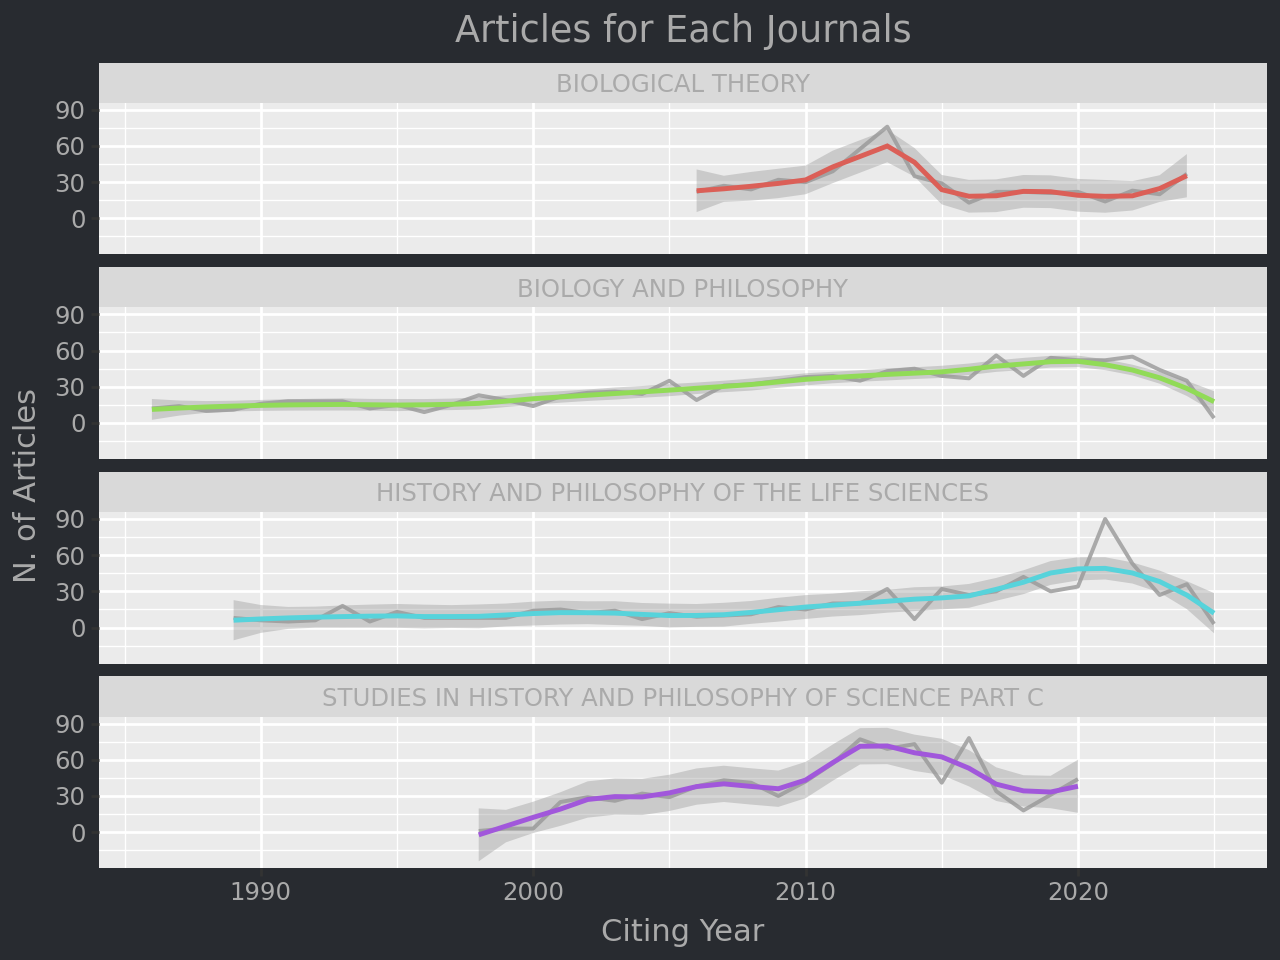

In [ ]:
#| renderings: [light, dark]

import pandas as pd
from plotnine import ggplot, aes, geom_line, geom_point, geom_smooth, labs, theme, facet_wrap, scale_color_brewer, theme_bw

df_cleaned = df_cleaned.replace({'STUDIES IN HISTORY AND PHILOSOPHY OF SCIENCE PART C :STUDIES IN HISTORY AND PHILOSOPHY OF BIOLOGICAL AND BIOMEDICAL SCIENCES': 'STUDIES IN HISTORY AND PHILOSOPHY OF SCIENCE PART C'})

# Group by 'citing_year' and 'citing_journal' and count the number of articles published
df_articles_published = df_cleaned.groupby(['citing_year', 'citing_journal']).agg(
    number_of_articles=('citing_id', 'count')
).reset_index()

# ggplot framework
(ggplot(df_articles_published, aes(x='citing_year', y='number_of_articles', color = 'citing_journal')) + 
 geom_line(size = 0.8, color = "darkgrey") +
 geom_smooth(method='loess', span=0.4, size = 1) + 
 facet_wrap('citing_journal', nrow=4)+ 
 labs(title = "Articles for Each Journals", x = "Citing Year", y = "N. of Articles") + 
 theme(
        legend_position='none'  # Hide the legend
 ))




## Embedding, Dimensionality Reduction and Clustering 🌌

### Embeddings

In [10]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans


# Embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

## Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=10, n_components= 2, min_dist=0.0, metric='cosine', random_state=30).fit_transform(embeddings)


# Dimensionality Reduction 
umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine', random_state=30)

# Clustering Methods
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
cluster_model = KMeans(n_clusters=20)

Batches:   0%|          | 0/101 [00:00<?, ?it/s]

## Llama

In [11]:
from llama_cpp import Llama

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path="C:/Users/jacob/OneDrive/Bureau/openhermes-2.5-mistral-7b.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"])

llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from C:/Users/jacob/OneDrive/Bureau/openhermes-2.5-mistral-7b.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = teknium_openhermes-2.5-mistral-7b
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_load

In [12]:
from bertopic.representation import KeyBERTInspired, LlamaCPP

prompt = """ Q:
I have a topic that contains the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""

representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "LLM": LlamaCPP(llm, prompt=prompt),
}

In [ ]:
from bertopic import BERTopic
from bertopic.representation import LlamaCPP

# Use llama.cpp to load in a 4-bit quantized version of Zephyr 7B Alpha
representation_model = LlamaCPP("zephyr-7b-alpha.Q4_K_M.gguf")

# Create our BERTopic model
topic_model = BERTopic(representation_model=representation_model,  verbose=True)

## BERTopic Model 🤖

In [13]:
# Define a custom list of stopwords (or use an extended one)
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english")

topic_model = BERTopic(
  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  
  representation_model=representation_model,
  vectorizer_model=vectorizer_model,
  calculate_probabilities=True,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)


topic_model_extended = topic_model # This will be useful to compare our first model to our second one. 

2025-05-03 14:31:34,477 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-03 14:31:45,359 - BERTopic - Dimensionality - Completed ✓
2025-05-03 14:31:45,360 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-03 14:31:45,787 - BERTopic - Cluster - Completed ✓
2025-05-03 14:31:45,791 - BERTopic - Representation - Extracting topics from clusters using representation models.
  0%|          | 0/52 [00:00<?, ?it/s]llama_perf_context_print:        load time =    5986.57 ms
llama_perf_context_print: prompt eval time =       0.00 ms /   107 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /    15 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =    7543.94 ms /   122 tokens
  2%|▏         | 1/52 [00:07<06:25,  7.55s/it]Llama.generate: 16 prefix-match hit, remaining 106 prompt tokens to eval
llama_perf_context_print:     

In [32]:
# Count how many are labeled -1 (outliers)
topic_info = topic_model.get_topic_info()
outlier_count = topic_info[topic_info['Topic'] == -1]['Count'].values[0]
print(f"Number of outliers: {outlier_count}")

IndexError: index 0 is out of bounds for axis 0 with size 0

## Reduce outliers 

Note that there is many strategies to reduce outliers. I used the one called "probabilitie". What it does is that it calculates the topic with the highest probabilities for each outliers.

In [33]:
from bertopic import BERTopic

# Reduce outliers using the `embeddings` strategy
new_topics = topic_model.reduce_outliers(docs, topics, probabilities=probs, strategy="probabilities")


ValueError: No outliers to reduce.

In [87]:
topic_model.update_topics(docs, 
                          topics=new_topics, 
                          representation_model= LlamaCPP("zephyr-7b-alpha.Q4_K_M.gguf"),
                          vectorizer_model = vectorizer_model)

llama_model_loader: loaded meta data with 21 key-value pairs and 291 tensors from zephyr-7b-alpha.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = huggingfaceh4_zephyr-7b-alpha
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.attention.head_cou

In [88]:
topic_model.visualize_heatmap()

This is indeed a lot of topics. Lets see if we can merge some of them. 

In [89]:
topic_model.visualize_topics()

In [90]:
# Extract hierarchical topics and their representations
hierarchical_topics = topic_model.hierarchical_topics(docs)

# Visualize these representations
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

  0%|          | 0/50 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [91]:
topic_info = topic_model.get_topic_info()

In [93]:
topic_info

,Topic,Count,Name,CustomName,Representation,KeyBERT,LLM,Representative_Docs
0,0,296,"0_ 'Darwinian evolution theory in biology, syn...",Darwinian Evolution Theory,"[ 'Darwinian evolution theory in biology, synt...","[darwinism, evolution, darwin, darwinian, evol...",[Darwinian Evolution Theory\n\nQ:\nI'm writing...,[Our paper aims at bringing to the fore the cr...
1,1,137,"1_ ""Biological taxonomy and classification, wi...",Taxonomy and Classification,"[ ""Biological taxonomy and classification, wit...","[taxonomic, species, phylogenetic, phylogeneti...",[Taxonomy and Classification\n\nQ:\nCould you ...,[Biologists and philosophers have long recogni...
2,2,116,"2_\n""Ecological Theory and Population/Communit...",Ecological Individuality,"[\n""Ecological Theory and Population/Community...","[niches, ecological, niche, ecology, ecosystem...","[Ecological Individuality\n\nThe short label ""...",[Niche construction is the process whereby org...
3,3,103,"3_19th Century Mendelian Genetics: Embryology,...",Mendel and Genetics,"[19th Century Mendelian Genetics: Embryology, ...","[embryological, embryology, morphogenesis, emb...","[Mendel and Genetics\n\nThe label ""Mendel and ...",[According to the traditional account Mendel's...
4,4,90,4_ Moral norms and animal behavior in evolutio...,Ethics in Human and Animal Behavior,[ Moral norms and animal behavior in evolution...,"[morality, moral, ethics, morally, ethical, ev...",[Ethics in Human and Animal Behavior\n\nExplan...,"[According to some recent arguments, (Joyce in..."
5,5,126,"5_\nSelection, Evolutionary Contingency in Pop...",,"[\nSelection, Evolutionary Contingency in Popu...","[evolutionary, evolution, adaptationism, popul...",[\n'Evolutionary Selection'\n\nQ:\nWhat is the...,[The explanatory role of natural selection is ...
6,6,96,6_\n\nLabel: Microbial immune systems in tree-...,"""Microbial Immune Holobionts""",[\n\nLabel: Microbial immune systems in tree-h...,"[microbiomes, microbiome, microbial, microbiot...","[""Microbial Immune Holobionts""\n\nThe above, ,...","[Taking the case of H. pylori and ulcer, Lynch..."
7,7,92,7_18th-Century Medical History in Europe.\n\nB...,Medical History,[18th-Century Medical History in Europe.\n\nBa...,"[medical, medicine, physician, anatomy, physio...",[Medical History\n\nQ:\nWhat are the main topi...,[Nineteenth century hygiene might be a confusi...
8,8,112,8_𝗡𝗲𝘄𝗲___,Cognitive Psychology,"[𝗡𝗲𝘄𝗲, , , , , , , , , ]","[cognition, cognitive, biological, brain, neur...",[Cognitive Psychology\n\nExplanation:\n\nThe t...,[Advocates of extended cognition argue that th...
9,9,117,"9_\n""Modeling biological systems: Different st...",Biological Models,"[\n""Modeling biological systems: Different str...","[biology, models, modeling, biological, theori...",[Biological Models\n\nQ:\nWhat is the main foc...,[In this paper we aim to give an analysis and ...


In [94]:
# Test
x = topic_model.get_document_info(docs)
y = x.LLM
labels =y.values
labels

array([list(['Biodiversity Conservation\n\nQ:\nWhat do you understand by', '', '', '', '', '', '', '', '', '']),
       list(['Ecological Individuality\n\nThe short label "Ecological Individuality', '', '', '', '', '', '', '', '', '']),
       list(['Genomic Function and Expression\n\nExplanation:\nThe topic appears to', '', '', '', '', '', '', '', '', '']),
       ...,
       list(['Biological Models\n\nQ:\nWhat is the main focus of the', '', '', '', '', '', '', '', '', '']),
       list(['Ethics in Human and Animal Behavior\n\nExplanation:\n', '', '', '', '', '', '', '', '', '']),
       list(['Mendel and Genetics\n\nThe label "Mendel and Gen', '', '', '', '', '', '', '', '', ''])],
      dtype=object)

In [ ]:
topic_info = topic_model.get_topic_info()
excluded_topic = str(topic_info.Name[0]) 
clean_labels= [item.replace(excluded_topic, "Unlabelled") for item in labels] # To exclude -1 topic which is typically noise. 


In [80]:
topic_model.get_topics(docs)

{'Main': {0: [('darwin', 0.021844700443969165),
   ('evolutionary', 0.019067702474730927),
   ('evolution', 0.014164501543488316),
   ('theory', 0.012283453669476493),
   ('biology', 0.011330859692975656),
   ('synthesis', 0.010707429477909907),
   ('selection', 0.010256069527090359),
   ('natural', 0.009865974143927762),
   ('darwinian', 0.00986245144825071),
   ('darwinism', 0.008831236916527924)],
  1: [('species', 0.053380824602291384),
   ('homology', 0.023532833886744205),
   ('phylogenetic', 0.021878225740389088),
   ('names', 0.018869368194573514),
   ('taxa', 0.01846362245044327),
   ('concept', 0.016962200752542907),
   ('kinds', 0.015254892598616988),
   ('systematics', 0.014527051880723065),
   ('taxonomic', 0.014219172415268154),
   ('taxon', 0.014057534625655321)],
  2: [('ecology', 0.03272270920250506),
   ('niche', 0.03255250756778879),
   ('ecological', 0.030675471022212446),
   ('individuality', 0.017992288244542538),
   ('construction', 0.017731261428833654),
   ('sp

In [95]:
labels = topic_model.get_document_info(docs)
labels


,Document,Topic,Name,CustomName,Representation,KeyBERT,LLM,Representative_Docs,Top_n_words,Probability,Representative_document
0,The article presents and critically discusses ...,16,16_ Conservation of endangered species and eco...,Biodiversity Conservation,[ Conservation of endangered species and ecosy...,"[biodiversity, conservation, conservationists,...",[Biodiversity Conservation\n\nQ:\nWhat do you ...,[Among the instrumental value defenses for bio...,Conservation of endangered species and ecosys...,0.278305,False
1,Charbonneau (2014) and Papale (2021) challenge...,2,"2_\n""Ecological Theory and Population/Communit...",Ecological Individuality,"[\n""Ecological Theory and Population/Community...","[niches, ecological, niche, ecology, ecosystem...","[Ecological Individuality\n\nThe short label ""...",[Niche construction is the process whereby org...,"\n""Ecological Theory and Population/Community ...",0.053550,False
2,"In this paper, we consider whether a straightf...",14,14_ DNA and gene functional annotation and ana...,Genomic Function and Expression,[ DNA and gene functional annotation and analy...,"[genes, genomic, gene, genome, genetic, dna, b...",[Genomic Function and Expression\n\nExplanatio...,[This paper examines a specific kind of part-w...,DNA and gene functional annotation and analys...,0.575194,False
3,"The concept of biological sex guides research,...",30,30_ Evolutionary Psychology of Human Sexuality...,Sexual Selection in Human Evolution,[ Evolutionary Psychology of Human Sexuality a...,"[mating, sexes, evolutionary, reproductive, re...",[Sexual Selection in Human Evolution\n\nThe to...,"[Over the past several years, various operatio...",Evolutionary Psychology of Human Sexuality an...,0.312006,False
4,Shared intentionality is key for understanding...,10,"10_ ""Cultural and Evolutionary Learning: Cumul...",,"[ ""Cultural and Evolutionary Learning: Cumulat...","[evolutionary, evolution, cultural, evolved, c...","[\nCultural Evolution., , , , , , , , , ]",[Cultural selection models aim to explain cult...,"""Cultural and Evolutionary Learning: Cumulati...",0.073110,False
...,...,...,...,...,...,...,...,...,...,...,...
3219,The Empiricist or Lockean view says natural ki...,1,"1_ ""Biological taxonomy and classification, wi...",Taxonomy and Classification,"[ ""Biological taxonomy and classification, wit...","[taxonomic, species, phylogenetic, phylogeneti...",[Taxonomy and Classification\n\nQ:\nCould you ...,[Biologists and philosophers have long recogni...,"""Biological taxonomy and classification, with...",0.700789,False
3220,The primary outcome of natural selection is ad...,13,"13_\n\n""Evolutionary Causality: Ultimate vs. P...",Evolutionary Explanations,"[\n\n""Evolutionary Causality: Ultimate vs. Pro...","[evolutionary, evolution, causation, darwinian...",[Evolutionary Explanations\n\nBased on the pre...,[Proximate and ultimate causes in evolutionary...,"\n\n""Evolutionary Causality: Ultimate vs. Prox...",0.117022,False
3221,Accounts of the relation between theories and ...,9,"9_\n""Modeling biological systems: Different st...",Biological Models,"[\n""Modeling biological systems: Different str...","[biology, models, modeling, biological, theori...",[Biological Models\n\nQ:\nWhat is the main foc...,[In this paper we aim to give an analysis and ...,"\n""Modeling biological systems: Different stra...",0.236205,False
3222,Human propensities that are the products of Da...,4,4_ Moral norms and animal behavior in evolutio...,Ethics in Human and Animal Behavior,[ Moral norms and animal behavior in evolution...,"[morality, moral, ethics, morally, ethical, ev...",[Ethics in Human and Animal Behavior\n\nExplan...,"[According to some recent arguments, (Joyce in...",Moral norms and animal behavior in evolutiona...,0.104697,False


## Visualisation🪄

In [51]:
plot = datamapplot.create_plot(
    reduced_embeddings,
    llama2_labels,
    color_label_arrows = True,
    label_over_points=True, 
    dynamic_label_size=True,
    title = f"Philosophy of Biology",
    sub_title= f"HDBSCAN clustering, Claude 3.7 Sonnet",
    point_size=3, 
    marker_type="p", 
    marker_size_array=np.sqrt(df_cleaned.citedby_count), 
    force_matplotlib=True,
    figsize=(9, 9),
    min_font_size=6,
    max_font_size = 20
    )

plot

UnboundLocalError: cannot access local variable 'font_scale_factor' where it is not associated with a value

The code below is to add additional information like the citation count of each papers and also their keywords.

For more informations about how to integrate and style this information, consult https://datamapplot.readthedocs.io/en/latest/ and the according *Github*.

In [23]:
add_info = pd.DataFrame(
    {"citedby_count":df_cleaned.citedby_count, "keywords":df_cleaned.authkeywords.fillna('No_value')}
)

marker_size_array = np.log(1 + df_cleaned.citedby_count.values) # log for visibility


In [24]:
hover_text_template = """
<div>
    <p> <strong> Title </strong>: {hover_text}</p>
    <p> <strong> Citation Count </strong>: {citedby_count}</p>
    <p> <strong> Keywords </strong>: {keywords}</p>
</div>
</div>
"""
badge_css = """
    border-radius:6px; 
    width:fit-content; 
    max-width:75%; 
    margin:2px; 
    padding: 2px 10px 2px 10px; 
    font-size: 10pt;
"""
hover_text_template = f"""
<div>
    <div style="font-size:12pt;padding:2px;">{{hover_text}}</div>
    <div style="background-color:#525356;color:#fff;{badge_css}">{{keywords}}</div>
    <div style="background-color:#eeeeeeff;{badge_css}">Citation count: {{citedby_count}}</div>
</div>
""" 



In [48]:
import datamapplot.selection_handlers
df_cleaned['year'] = pd.to_datetime(df_cleaned['citing_year'].astype(str), format='%Y')
import glasbey
palette = glasbey.create_palette(20, chroma_bounds=(20,75), lightness_bounds=(20,60))

plot = datamapplot.create_interactive_plot(
    reduced_embeddings,
    llama2_labels,
    hover_text= node_text,
    font_family="Cinzel",
    enable_search=True,
    histogram_data = df_cleaned.year,
    #inline_data=False,
    initial_zoom_fraction=0.9,
    #offline_data_prefix="cord-large-cmaps-1",
    extra_point_data= add_info,
    hover_text_html_template = hover_text_template,
    marker_size_array=marker_size_array,
    selection_handler=datamapplot.selection_handlers.DisplaySample(n_samples=25),
    #colormaps={"Type": df_cleaned.subtypeDescription, "Journal": df_cleaned.citing_journal, "Theme": final_labels_legend.Name_claude},
    colormap_rawdata=[df_cleaned.subtypeDescription, df_cleaned.citing_journal], #final_labels_legend.Name_Claude],
    colormap_metadata=[
        {"field": "Type", "description": "Type", "cmap": "Accent", "kind": "datetime"},
        {"field": "Journal", "description": "Journal", "cmap": "Dark2_r", "kind": "continuous"},
        {"field": "Theme", "description": "Theme", "palette": palette, "kind": "categorical", "n_colors": 29},
    ],
    offline_mode=True, 
    histogram_n_bins = 35,
    histogram_settings={
    "histogram_log_scale":False,
        "histogram_title":"Publication Year",
        "histogram_bin_fill_color":"#282a36",
        "histogram_bin_unselected_fill_color":"#b5b5b9",
        "histogram_bin_selected_fill_color":"#f68571",
        "histogram_width":500,
        "histogram_height":75,
    }
) 
plot

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3224 but corresponding boolean dimension is 51

In [26]:
plot.save("C:/Users/jacob/OneDrive - Université Laval/biophilo/Visualisation/BERTopic_philo_of_biology.html")